# Estudio comparativo de algoritmos UCB en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos UCB en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: María Castillo Blaya, Juan José López Quiñonero
    Email: m.castilloblaya@um.es jjose.lopez@um.es
    Date: 2025/06/21

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html


## Preparación del entorno


Descargamos el repositorio

In [1]:
!git clone https://github.com/JuanjoLQ/k_brazos_CBLQ.git
!cd k_brazos_CBLQ/

Cloning into 'k_brazos_CBLQ'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 30 (delta 4), reused 30 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 2.92 MiB | 9.63 MiB/s, done.
Resolving deltas: 100% (4/4), done.


Importamos todas las clases y funciones que iremos utilizando a lo largo del notebook.

In [2]:
import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_CBLQ')
sys.path.append('/content/k_brazos_CBLQ/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, UCB1, UCB2
from arms import ArmNormal, ArmBinomial, ArmBernoulli, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/k_brazos_CBLQ', '/content/k_brazos_CBLQ/src']


## **Experimento**

Cada algoritmo se ejecuta en un problema del **bandido de K-brazos (K-Armed Bandit)** durante un número determinado de pasos de tiempo y ejecuciones. El objetivo es comparar el rendimiento de los algoritmos en función de la **recompensa promedio** obtenida a lo largo del tiempo.

### **Metodología del Experimento**

1. Se define un entorno con **K brazos**, cada uno con una distribución de recompensas desconocida.
2. Se seleccionan uno o más algoritmos (por ejemplo, variantes de UCB) y se configuran con diferentes **valores de hiperparámetros**.
3. Cada algoritmo se ejecuta durante un total de **1000 pasos**.
4. El experimento completo se repite **500 veces** (ejecuciones independientes) para obtener una estimación robusta del rendimiento.
5. Para cada paso en el tiempo, se calcula la **recompensa promedio** obtenida por el algoritmo, promediando sobre las 500 ejecuciones.

### **Ejemplo: Comparación de UCB**

En un entorno con **K brazos**, se comparan dos variantes del algoritmo **UCB (Upper Confidence Bound)** utilizando distintos valores para sus parámetros de exploración. El propósito es observar cómo afecta este parámetro a la exploración temprana y a la convergencia hacia los brazos óptimos.

### **Evaluación**

Los resultados se representan mediante gráficas de:
- **Recompensa promedio** por paso.
- **Porcentaje de selección del brazo óptimo**.
- **Regret acumulado** (opcional).

Estas métricas permiten visualizar la eficiencia del algoritmo en encontrar y explotar el mejor brazo, así como su capacidad para equilibrar la exploración-explotación.

In [3]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Brazo óptimo para evaluar selecciones correctas

    rewards = np.zeros((len(algorithms), steps))  # Matriz de recompensas promedio
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz de selecciones óptimas
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz de regret acumulado
    arm_stats = [None] * len(algorithms)  # Almacena estadísticas finales

    np.random.seed(seed)  # Fijar semilla para reproducibilidad

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)  # Clonar el bandido para cada ejecución

        for algo in algorithms:
            algo.reset()  # Reiniciar los valores de los algoritmos

        total_rewards_per_algo = np.zeros(len(algorithms))  # Acumulador de recompensas
        optimal_reward = bandit.get_expected_value(optimal_arm)  # Valor esperado del brazo óptimo

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()

                reward = current_bandit.pull_arm(chosen_arm)  # Obtener recompensa
                algo.update(chosen_arm, reward)

                rewards[idx, step] += reward  # Acumular recompensa
                total_rewards_per_algo[idx] += reward  # Recompensa total por algoritmo

                # Calcular regret acumulado
                if step == 0:
                    regret_accumulated[idx, step] = optimal_reward - current_bandit.get_expected_value(chosen_arm)  # Primera iteración
                else:
                    regret_accumulated[idx, step] = regret_accumulated[idx, step-1] + (optimal_reward - current_bandit.get_expected_value(chosen_arm))

                # Contabilizar selecciones óptimas
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

        # Almacenar estadísticas finales de los brazos
        for idx, algo in enumerate(algorithms):
            if arm_stats[idx] is None:
                arm_stats[idx] = {
                    "mean_rewards": algo.values.copy(),
                    "selection_counts": algo.counts.copy(),
                    "optimal_arm": optimal_arm
                }

    rewards /= runs  # Promediar recompensas

    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections /= runs  # Promediar selecciones óptimas

    return rewards, optimal_selections, regret_accumulated, arm_stats

## **Ejecución del Experimento y Visualización de los Resultados**

El experimento se lleva a cabo en un entorno con **10 brazos**, donde cada brazo genera recompensas siguiendo una **distribución gaussiana** con desviación estándar igual a **1**.

Se realizan **500 ejecuciones independientes**, cada una compuesta por **1000 pasos**, para garantizar resultados estadísticamente significativos.

### **Algoritmos Evaluados**

Se evalúan variantes del algoritmo **UCB (Upper Confidence Bound)** modificando dos de sus hiperparámetros principales:

- **Parámetro `c`** (controla el grado de exploración):  
  Se prueban los valores: **0.5**, **1**, y **2**.
  
- **Tasa de aprendizaje `α` (alpha)**:  
  Se prueban los valores: **0.1**, **0.5**, y **1**.

Estas combinaciones permiten estudiar cómo afectan estos parámetros al comportamiento y desempeño del algoritmo UCB.

### **Visualización de Resultados**

Se generan gráficos que permiten comparar el rendimiento de los algoritmos, incluyendo:

- **Recompensa promedio por paso de tiempo**:  
  Muestra cómo evoluciona la calidad de las decisiones del agente a lo largo del tiempo.

- **Porcentaje de selección del brazo óptimo**:  
  Indica qué tan frecuentemente cada algoritmo identifica y selecciona el mejor brazo.

- **Regret acumulado (opcional)**:  
  Mide la pérdida total debida a no elegir siempre el mejor brazo, útil para evaluar la eficiencia del aprendizaje.

Estas visualizaciones permiten comparar de forma intuitiva el impacto de los parámetros `c` y `α` sobre el desempeño general del algoritmo.


Evaluando UCB con brazos Bernoulli...
Bandit with 10 arms: ArmBernoulli(p=0.59), ArmBernoulli(p=0.90), ArmBernoulli(p=0.89), ArmBernoulli(p=0.82), ArmBernoulli(p=0.04), ArmBernoulli(p=0.69), ArmBernoulli(p=0.38), ArmBernoulli(p=0.52), ArmBernoulli(p=0.66), ArmBernoulli(p=0.19)
Optimal arm: 2 with expected reward=0.897713727909418


/content/k_brazos_CBLQ/src/algorithms/ucb2.py:32: RuntimeWarning: invalid value encountered in sqrt
  ucb_values = self.values + np.sqrt(



Resultados para Bernoulli:


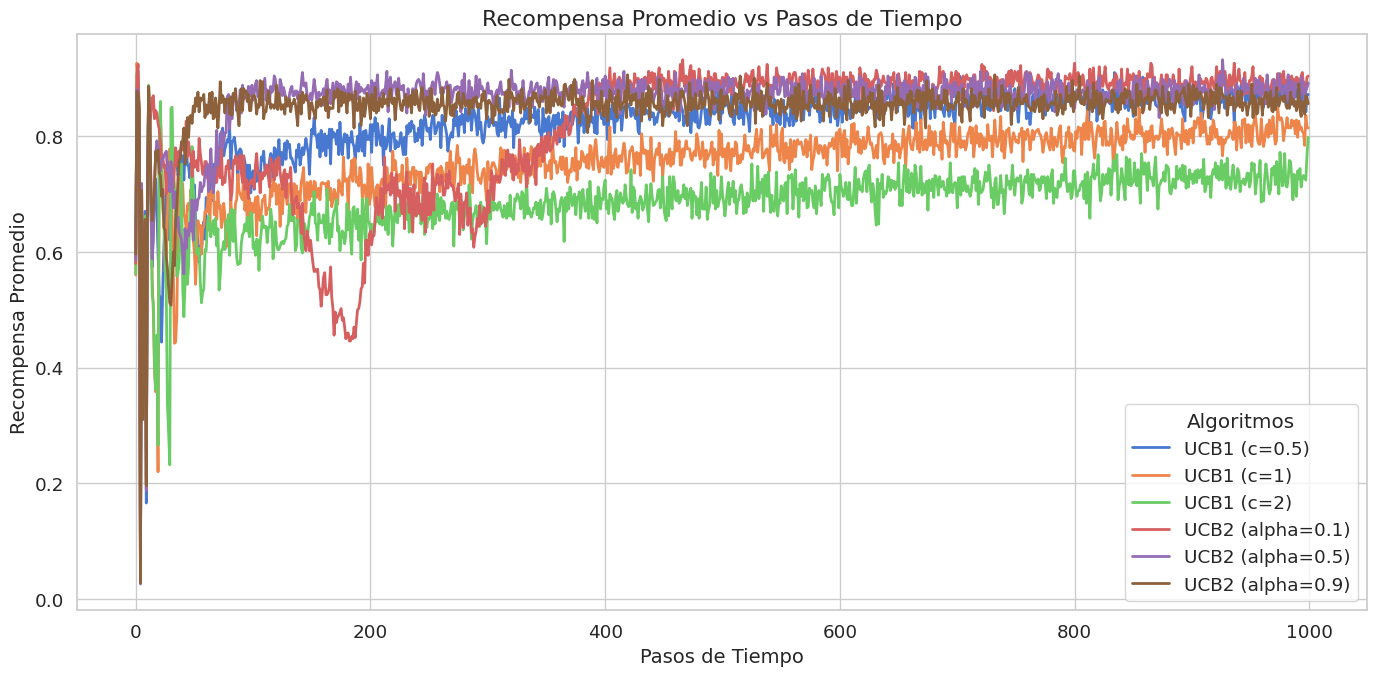

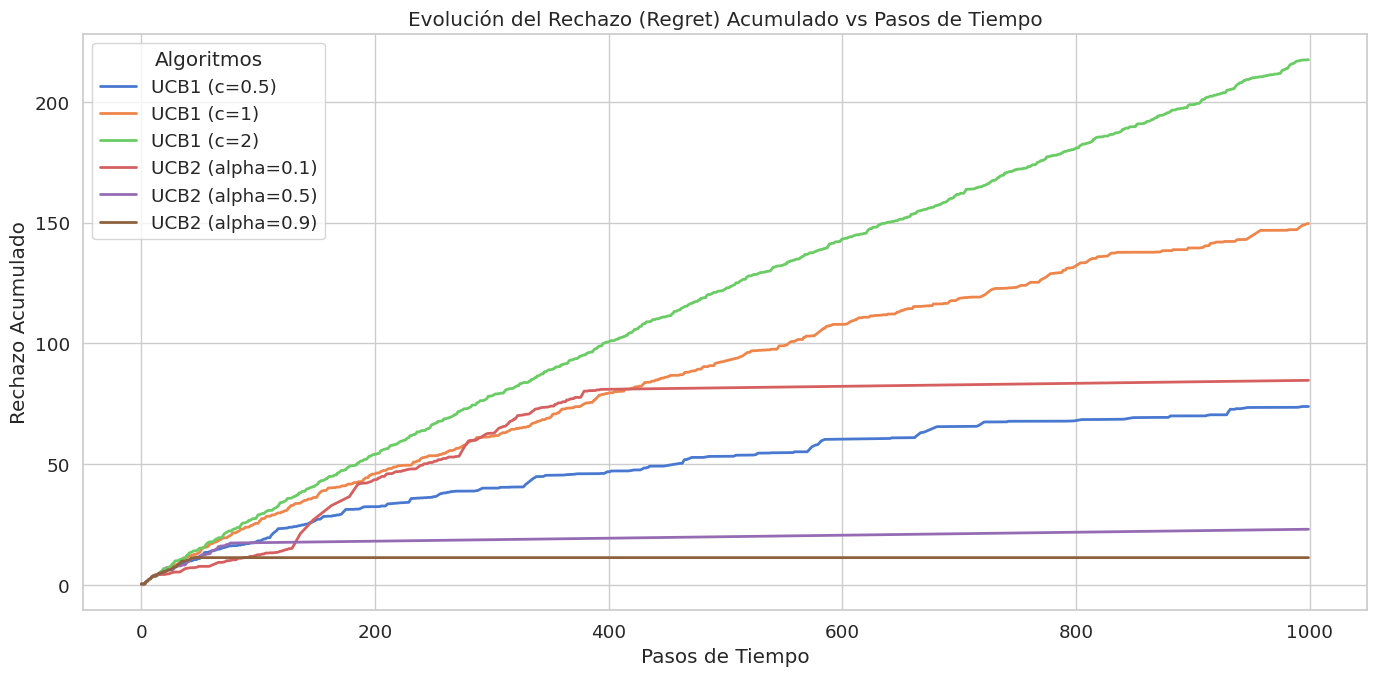


Evaluando UCB con brazos Binomial...
Bandit with 10 arms: ArmBinomial(n=10, p=0.35), ArmBinomial(n=10, p=0.12), ArmBinomial(n=10, p=0.63), ArmBinomial(n=10, p=0.20), ArmBinomial(n=10, p=0.60), ArmBinomial(n=10, p=0.96), ArmBinomial(n=10, p=0.10), ArmBinomial(n=10, p=0.28), ArmBinomial(n=10, p=0.72), ArmBinomial(n=10, p=0.75)
Optimal arm: 6 with expected reward=9.575154188892597

Resultados para Binomial:


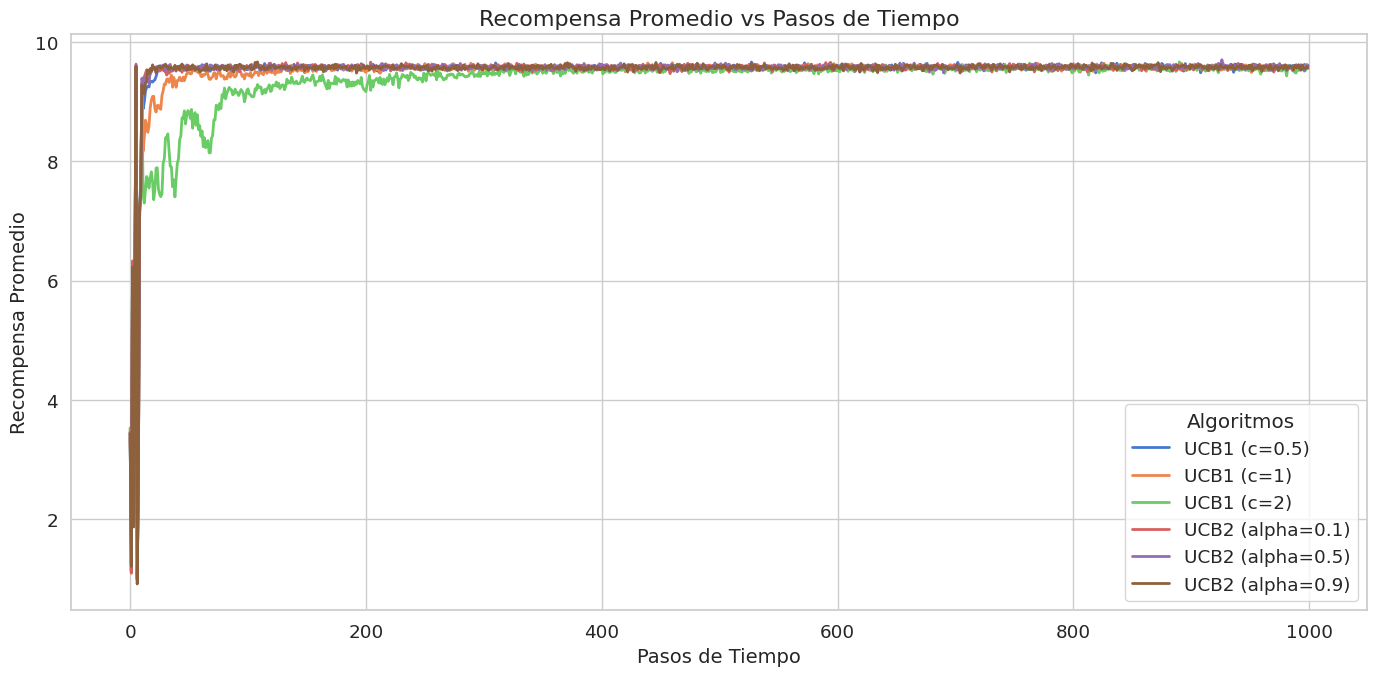

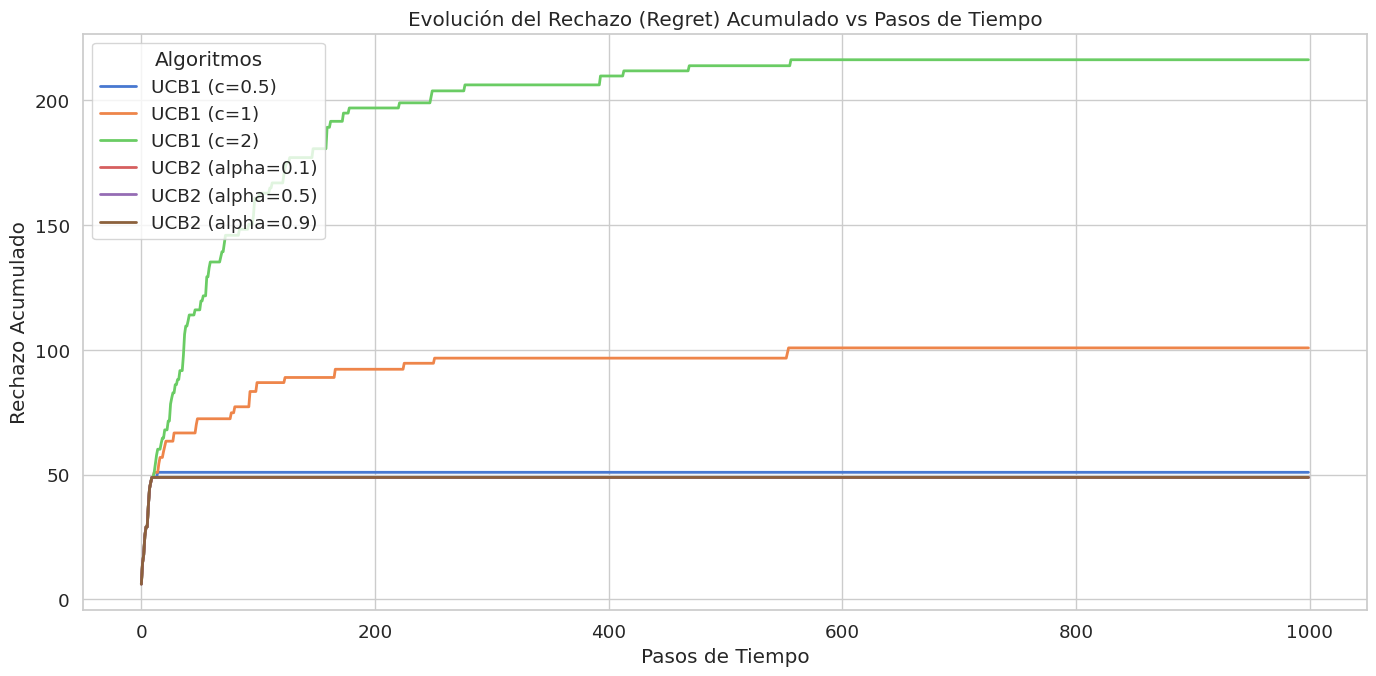


Evaluando UCB con brazos Normal...
Bandit with 10 arms: ArmNormal(mu=1.9, sigma=1.0), ArmNormal(mu=2.04, sigma=1.0), ArmNormal(mu=2.78, sigma=1.0), ArmNormal(mu=4.11, sigma=1.0), ArmNormal(mu=3.49, sigma=1.0), ArmNormal(mu=6.65, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.46, sigma=1.0), ArmNormal(mu=9.62, sigma=1.0), ArmNormal(mu=7.77, sigma=1.0)
Optimal arm: 9 with expected reward=9.62


/content/k_brazos_CBLQ/src/algorithms/ucb2.py:32: RuntimeWarning: invalid value encountered in sqrt
  ucb_values = self.values + np.sqrt(
/content/k_brazos_CBLQ/src/algorithms/ucb2.py:32: RuntimeWarning: invalid value encountered in sqrt
  ucb_values = self.values + np.sqrt(



Resultados para Normal:


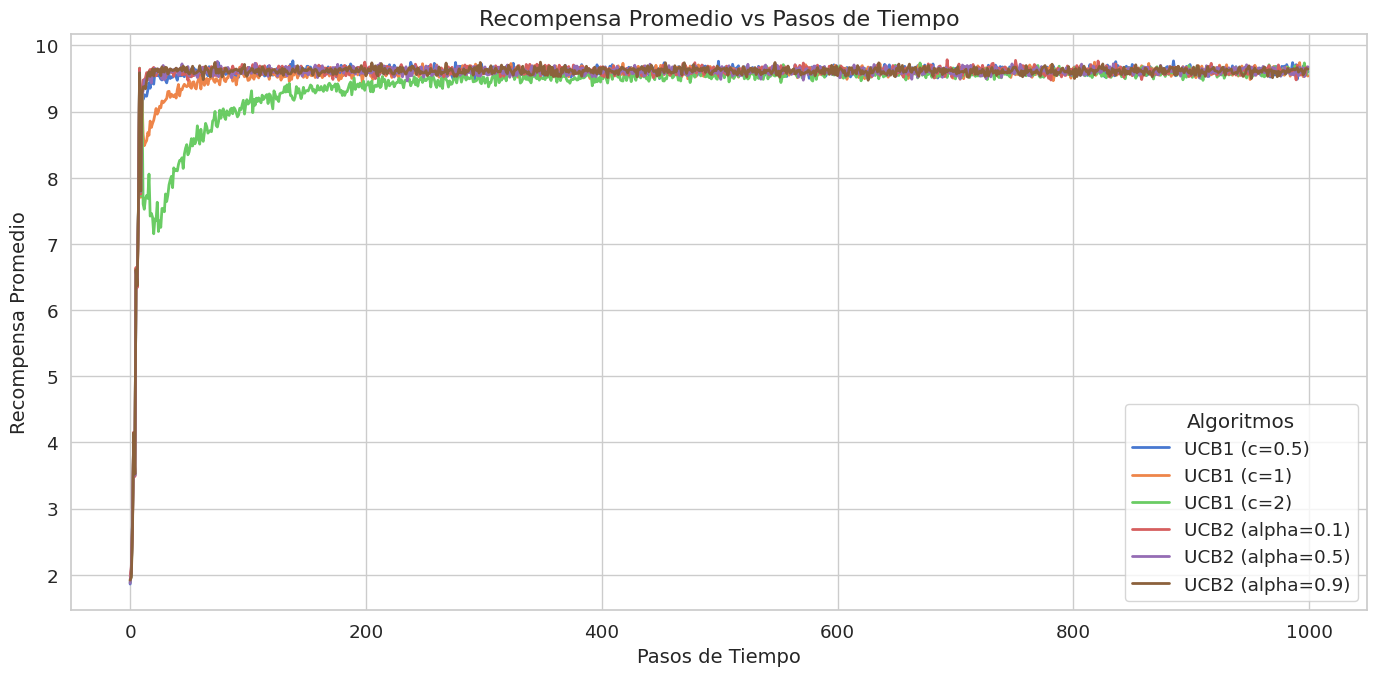

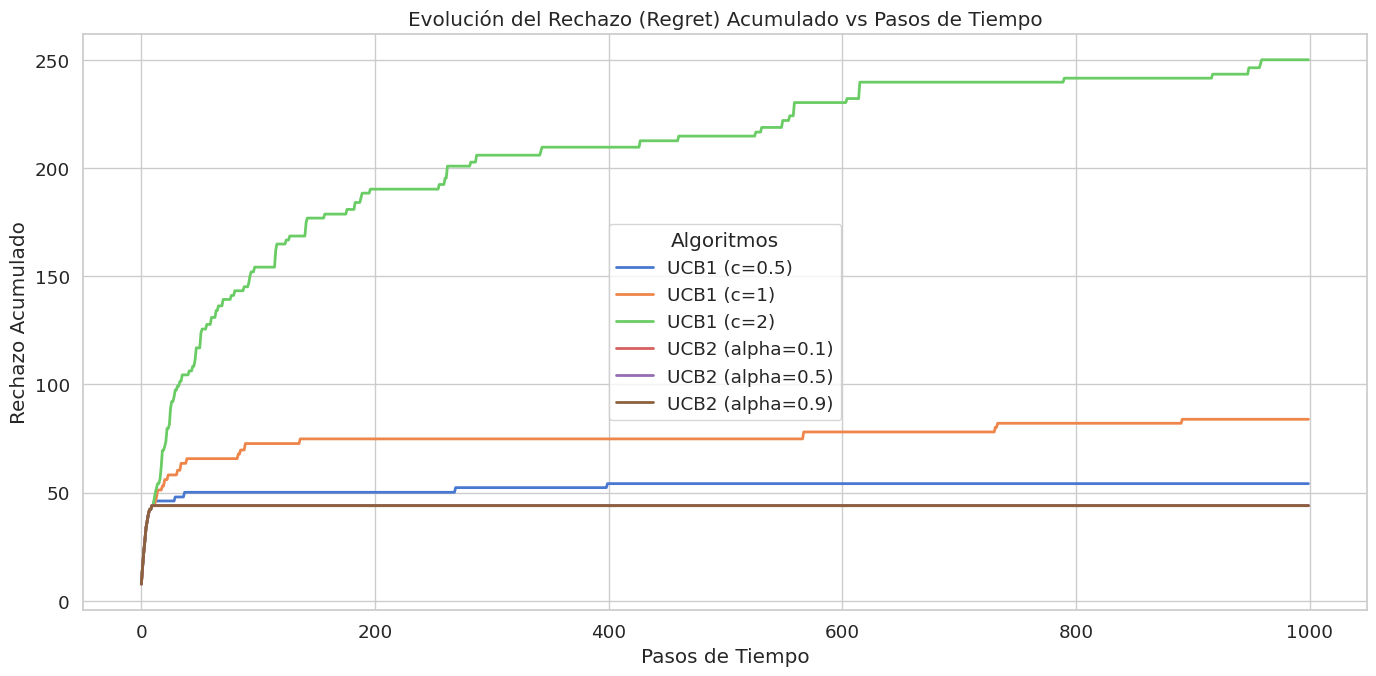

In [4]:
# Parámetros del experimento
seed = 20
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Tipos de brazos que se van a utilizar en el experimento
arm_types = {
    'Bernoulli': ArmBernoulli,
    'Binomial': ArmBinomial,
    'Normal': ArmNormal
}

# Definir los hiperparámetros a comparar para cada algoritmo UCB
ucb1_configs = [0.5, 1, 2]  # Valores del parámetro 'c' en UCB1
ucb2_configs = [0.1, 0.5, 0.9]  # Valores del parámetro 'alpha' en UCB2

# Definir los algoritmos a comparar en la familia UCB con diferentes configuraciones
algorithms = []

# Añadir UCB1 con diferentes valores de 'c'
for c in ucb1_configs:
    algorithms.append(UCB1(k=k, c=c))

# Añadir UCB2 con diferentes valores de 'alpha'
for alpha in ucb2_configs:
    algorithms.append(UCB2(k=k, alpha=alpha))

# Bucle para evaluar cada tipo de brazo con los algoritmos definidos
for arm_name, ArmClass in arm_types.items():
    print(f"\nEvaluando UCB con brazos {arm_name}...")

    # Creación del bandit con el tipo de brazo correspondiente
    bandit = Bandit(arms=ArmClass.generate_arms(k))  # Generar un bandido con k brazos según la distribución del tipo de brazo actual
    print(bandit)

    # Obtener el brazo óptimo y su recompensa esperada
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

    # Ejecutar el experimento
    rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)

    # Graficar los resultados específicos para este tipo de brazo
    print(f"\nResultados para {arm_name}:")
    plot_average_rewards(steps, rewards, algorithms)
    plot_regret(steps, regret_accumulated, algorithms)


# Análisis detallado: Rendimiento de la familia UCB en entornos con distintas distribuciones

Este análisis se basa en la evaluación empírica de los algoritmos UCB1 y UCB2 en un entorno de k-armed bandit, considerando tres tipos de distribución para las recompensas:

- Bernoulli (recompensas binarias)  
- Binomial (repeticiones discretas con éxito)  
- Normal (recompensas continuas)

Se exploran diferentes valores de hiperparámetros (`c` para UCB1 y `α` para UCB2), midiendo su impacto en:
- Recompensa promedio a lo largo del tiempo
- Regret acumulado
- Selección del brazo óptimo (implícito en las métricas anteriores)

---

## 1. Recompensa promedio vs pasos de tiempo

Este gráfico permite observar la eficiencia del aprendizaje de cada algoritmo.

### UCB1 (c = 0.5, 1, 2)
- `c = 0.5` y `c = 1` logran una recompensa alta y convergen rápidamente.
- `c = 2` demora más en estabilizarse, lo que indica sobreexploración.

### UCB2 (α = 0.1, 0.5, 0.9)
- `α = 0.9` obtiene las mejores recompensas promedio, adaptándose eficientemente.
- `α = 0.5` también ofrece un rendimiento sólido, pero inferior a `α = 0.9` en Normal y Binomial.
- `α = 0.1` muestra bajo desempeño, especialmente en Bernoulli y Binomial.

### Comparación por distribución
- Bernoulli: Mejor desempeño con UCB2(α=0.5) y UCB1(c=0.5).
- Binomial: Similar a Bernoulli, aunque UCB2(α=0.9) toma la delantera.
- Normal: UCB1(c=0.5) y UCB2(α=0.9) son los más eficaces.

---

## 2. Regret acumulado vs pasos de tiempo

Esta métrica refleja cuánto pierde el algoritmo por no elegir el brazo óptimo.

### UCB1
- `c = 0.5` presenta el regret más bajo en todos los escenarios.
- `c = 1` tiene un comportamiento intermedio.
- `c = 2` acumula más regret debido a su alta exploración.

### UCB2
- `α = 0.9` logra el menor regret, especialmente en distribuciones con mayor variabilidad.
- `α = 0.5` tiene un buen equilibrio.
- `α = 0.1` explora demasiado, lo que causa un regret elevado y persistente.

### Comparación por distribución
- Bernoulli y Binomial: UCB1(c=0.5) y UCB2(α=0.9) minimizan el regret.
- Normal: UCB1(c=0.5) sobresale por su robustez.

---

## 3. Interpretación cruzada

- UCB1(c = 0.5) y UCB2(α = 0.9) son las configuraciones más balanceadas.
- Las diferencias entre distribuciones no cambian el orden relativo de los algoritmos.
- UCB2(α=0.9) destaca más en Bernoulli y Binomial por su adaptabilidad.
- En Normal, UCB1(c=0.5) es más robusto gracias a la precisión de las recompensas continuas.

---

## Conclusiones Finales

### 1. Exploración vs Explotación
- En UCB1, valores bajos de `c` permiten una explotación más temprana.
- En UCB2, valores altos de `α` tienen un efecto similar.
- Valores extremos (c altos o α bajos) provocan sobreexploración innecesaria.

### 2. Impacto de los hiperparámetros
- UCB1(c=0.5) y UCB2(α=0.9) logran el mejor compromiso entre exploración y explotación.
- UCB1(c=2) y UCB2(α=0.1) tienden a explorar demasiado, aumentando el regret.

### 3. Regret acumulado como métrica principal
- Refleja cuán cerca está el algoritmo de un comportamiento óptimo.
- Es clave para evaluar rendimiento a largo plazo.

### 4. Influencia de la distribución
- Bernoulli y Binomial favorecen a UCB2(α=0.9).
- Normal favorece a UCB1(c=0.5) por la estabilidad de las recompensas continuas.

---

## Conclusión general

El rendimiento de UCB1 y UCB2 depende fuertemente de la distribución de recompensas y de la configuración de sus hiperparámetros.

- UCB1(c=0.5) es sólido en entornos con recompensas continuas.  
- UCB2(α=0.9) es competitivo en entornos discretos o ruidosos.  
- Configuraciones con alta exploración (como c=2 o α=0.1) aumentan el regret y reducen la eficiencia.

Una correcta selección del algoritmo y sus parámetros es esencial para maximizar el rendimiento en problemas de decisión secuencial bajo incertidumbre.